## Activation Variance

This script is to illustrate the findings of X. Glorot and J. Bengio in their well known publication `Understanding the difficulty of training deep feedforward neural networks` (http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). Different initialisation schemes for the weights of a MLP can be chosen and the behaviour of the activation in the forward an backward path be observed.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Helper functions

In [2]:
def plot_activation_histogram(num_bins=200, range = [-0.5,0.5], fig_size = [6,4]):
    """
        show histogram of activations of all layers of NNet instance in one graph

        Arguments:
        num_bins -- set number of bins to use
        range -- it is important to fix the same range (-> bins) for all curves to make them comparable
        fig_size -- size of figure
    """
    fig = plt.figure(figsize=fig_size)
    ax = fig.subplots()

    last = -1 #we have no reference       
    for ind in np.arange(len(NNet.layers)):
        if NNet.layers[ind].__class__.__name__ == 'DenseLayer':    
            data = NNet.layers[ind].a_out.flatten()
    
            if last > 0:
                var_ratio = last/np.var(data)
                label_string = ('layer %d, r = %1.2f' % (ind, var_ratio))
            else:
                label_string = ('layer %d' % ind)
           
            ax.hist(data, bins=num_bins, range=range, histtype='step', label=label_string)
            #store std of last layer
            last = np.var(data)

    ax.set_ylabel('absolute frequency')
    ax.set_xlabel('activation value')
    ax.legend()
    plt.show()


def plot_gradient_histogram(num_bins=200, range = [-0.02,0.02], fig_size = [6,4]):
    """
        show histogram of gradients of all layers of NNet instance in one graph

        Arguments:
        num_bins -- set number of bins to use
        range -- it is important to fix the same range (-> bins) for all curves to make them comparable
        fig_size -- size of figure
    """
    fig = plt.figure(figsize=fig_size)
    ax = fig.subplots()

    last = -1 #we have no reference       
    for ind in np.arange(len(NNet.layers)-1):
        if NNet.layers[ind].__class__.__name__ == 'DenseLayer':    
            data = NNet.layers[ind].dL_da_in.flatten()
    
            if last > 0:
                var_ratio = np.var(data)/last #switched due to backprop
                label_string = ('layer %d, r = %1.2f' % (ind, var_ratio))
            else:
                label_string = ('layer %d' % ind)
           
            ax.hist(data, bins=num_bins, range=range, histtype='step', label=label_string)
            #store std of last layer
            last = np.var(data)

    ax.set_ylabel('absolute frequency')
    ax.set_xlabel('gradient value')
    ax.legend()
    plt.show()

### Batch Normalization Layer

Implementation of class for batch normalization layer (to be put after dense layer). This class is used by the class MultiLayerPerceptron below.

In [3]:
class BatchNormLayer:
    """
    constructs a batch normalization layer for a MLP
    """
    def __init__(self, size_in, eps = 1.0e-3):
        """
        constructor

        Arguments:
        size_in -- number of inputs (i.e. of neurons from previous layer)
        eps -- small number use to avoid division by zero (reduced for tests)
        """
        
        self.size_in = size_in
        self.size_out = size_in
        
        #average values of mu and sigma used for inference
        self.sigma_avg = np.ones((1, size_in))
        self.mu_avg = np.zeros((1, size_in))
        
        #parameters gamma and beta trained during back propagation
        self.gamma = np.ones((1, size_in))
        self.beta = np.zeros((1, size_in))
        
        self.eps = eps
        
        self.init = True
        
    def propagate(self, a_in, learn = False):
        """
        calculates the activation a_out based on activation from previous layer a_in
        
        Arguments:
        learn -- set to True during learning
        """
        
        if learn:
            #in case we are learning      
            
            ### START YOUR CODE ###
        
            mu = np.zeros([1,a_in.shape[1]])
            mu = 1/a_in.shape[0] * np.sum(a_in, axis=0, keepdims=True)
            self.sigma = np.sqrt(1/a_in.shape[0] * np.sum((a_in - mu)**2, axis=0, keepdims=True))
            self.a_in_scal = (a_in - mu) / (self.sigma + self.eps)

            ### END YOUR CODE ###   

            #determine average values of mu and sigma
            if self.init == True:
                #first training step
                self.mu_avg = mu
                self.sigma_avg = self.sigma
                self.init = False
            else:
                beta = 0.9
                self.mu_avg = beta*self.mu_avg + (1 - beta) * mu
                self.sigma_avg = beta*self.sigma_avg + (1 - beta) * self.sigma
                
        else:
            #for inference we scale inputs with average values of mu and sigma
            self.a_in_scal = (a_in - self.mu_avg) / (self.eps + self.sigma_avg)
          
        #rescaling of the activations with gamma and beta
        self.a_out = self.gamma * self.a_in_scal + self.beta
        
        return self.a_out
            
     
    def back_propagate(self, dL_da_out):
        """
        calculates the backpropagation results based on the gradient of cost wrt to output activations
        this function must be performed AFTER the corresponding propagte step
        """        
        
        ### START YOUR CODE ###

        m = dL_da_out.shape[0]
        self.dL_dgamma = np.sum(dL_da_out * self.a_in_scal, axis=0, keepdims=True) / m
        self.dL_dbeta = np.sum(dL_da_out, axis=0, keepdims=True) / m

        dL_da_in = (1. / m) * self.gamma * (m * dL_da_out - np.sum(dL_da_out, axis=0, keepdims=True) 
             - self.a_in_scal * np.sum(dL_da_out * self.a_in_scal, axis=0, keepdims=True)) / (self.sigma + self.eps)
        

        ### END YOUR CODE ###    
        
        return dL_da_in
        
        
    def gradient_descend(self, alpha):
        """
        does the gradient descend based on results from last back_prop step with learning rate alpha
        """
        self.gamma -= alpha * self.dL_dgamma
        self.beta -= alpha * self.dL_dbeta

### DenseLayer¶

Implementation of class for a simplified dense layer of MLP with different activation functions. This class is used by the class NeuralNetwork below.

In [4]:
class DenseLayer:
    """
    constructs a dense layer with for a MLP
    """
    def __init__(self, size_in, size_out, random_std = 0, activation = 'sigmoid'):
        """
        constructor

        Arguments:
        size_in -- number of inputs (i.e. of neurons from previous layer)
        size_out -- number of outputs (i.e. of neurons in this layer) 
        random_std -- std for initialisation of weight (default is 0)
        """
        
        self.size_in = size_in
        self.size_out = size_out
        self.activation = activation
        self.random_std = random_std
        
        # initialize weights and bias (zero or random)
        self.initialise_weights()
    
    def initialise_weights(self):
        """
        initialize weights and bias with uniform distribution
        """ 
        self.W = self.random_std * 2*(np.random.rand(self.size_in, self.size_out)-0.5)    
        self.B =  0*np.ones((1, self.size_out))#we apply a bias of value zero
        
              
    def propagate(self, a_in, learn = False):
        """
        calculates the activation a_out based on activation from previous layer a_in
        """    
        self.a_in = a_in
        self.Z = a_in @ self.W + self.B
        self.a_out = self.activation_function(self.Z)
        
        return self.a_out

    
    def activation_function(self, z):
        """
        apply activation function
        """
        if self.activation == 'sigmoid':
            return 1/(1+np.exp(-z))
        if self.activation == 'tanh':
            return (np.exp(z) - np.exp(-z))/(np.exp(z)+np.exp(-z))
        if self.activation == 'relu':
            return z*(z > 0)
    
    
    def d_activation_function(self, z):
        """
        calculates the derivative of the activation function
        """
        if self.activation == 'sigmoid':
            return self.activation_function(z)*(1 - self.activation_function(z))
        if self.activation == 'tanh':
            return 4/np.square(np.exp(z)+np.exp(-z))
        if self.activation == 'relu':
            return 1.*(z > 0)
            
     
    def back_propagate(self, dL_da_out):
        """
        calculates the backpropagation results based on the gradient of cost wrt to output activations
        this function must be performed AFTER the corresponding propagte step
        """    
        self.dL_da_out = dL_da_out
        dL_dz = dL_da_out*self.d_activation_function(self.Z)
        self.dL_da_in = dL_dz @ self.W.T
        
        return self.dL_da_in
           

## Class NeuralNetwork

Implementation of a MLP with configurable number of Dense Layers (only!). Only propagation and backpropagation methods are implemented.

In [5]:
class NeuralNetwork:
    """
    NN class handling the layers and doing all propagation and back-propagation steps
    """
    
    def __init__(self, list_num_neurons, random_std = 0, activation = 'sigmoid', batch_norm = True):
        """
        constructor

        Arguments:
        list_num_neurons -- list of neurons including in- and output layers
        random_std -- std for initialisation of weight (default is 0)      
        """
        self.layers = []
        #first construct dense layers (if any)
        for i0 in range(len(list_num_neurons)-1):
            new_layer = DenseLayer(list_num_neurons[i0], list_num_neurons[i0+1], random_std, activation)
            self.layers.append(new_layer)

            if batch_norm:
                new_layer = BatchNormLayer(list_num_neurons[i0+1])
                self.layers.append(new_layer)

    
    def propagate(self, x, learn = False):
        """
        calls successively propagate methods of all layers 
        result of each layer is passed to next layer
        """
        for layers in self.layers:
            x = layers.propagate(x, learn = learn)
            
        return x

     
    def back_propagate(self, y):
        """
        calls successively back_propagate methods of all layers 
        result of each layer is passed to next layer
        """
        #first do softmax with y as input
        dL_da_out = y
        #now the remaining layers
        for i0 in reversed(range(len(self.layers))):
            dL_da_out = self.layers[i0].back_propagate(dL_da_out)
            
        return dL_da_out

    
    def print_layers(self):
        ind = 1
        for layers in self.layers:
            print('layer [%r] is %r' % (ind, layers.__class__.__name__))
            print('#input is %r, #output is %r' % (layers.size_in, layers.size_out))
            if layers.__class__.__name__ == 'DenseLayer':                
                print('activation function is %r' % layers.activation)
                print('weight init std is %r' % layers.random_std)
            ind += 1
            print('')
           

## Network initialisation

Create a set of dummy input vectors x of given size and instantiate a network with given number of hidden layers and neurons

In [6]:
num_samples = 1000
num_feat = 100
num_classes = 100 #we choose the output to be of same size to have identical number of activations

#to avoid saturation in the first layer we choose a somewhat smaller standard deviation
stand_dev = 0.3
x = stand_dev*np.random.randn(num_samples, num_feat)

list_num_neurons = [num_feat, num_feat, num_feat, num_feat, num_feat, num_feat, num_classes]
#note the possible choice of activation function

### START YOUR CODE ###
NNet = NeuralNetwork(list_num_neurons, random_std = 1*np.sqrt(1/num_feat), activation = 'tanh', batch_norm = True)
### END YOUR CODE ###

NNet.print_layers()

layer [1] is 'DenseLayer'
#input is 100, #output is 100
activation function is 'tanh'
weight init std is 0.1

layer [2] is 'BatchNormLayer'
#input is 100, #output is 100

layer [3] is 'DenseLayer'
#input is 100, #output is 100
activation function is 'tanh'
weight init std is 0.1

layer [4] is 'BatchNormLayer'
#input is 100, #output is 100

layer [5] is 'DenseLayer'
#input is 100, #output is 100
activation function is 'tanh'
weight init std is 0.1

layer [6] is 'BatchNormLayer'
#input is 100, #output is 100

layer [7] is 'DenseLayer'
#input is 100, #output is 100
activation function is 'tanh'
weight init std is 0.1

layer [8] is 'BatchNormLayer'
#input is 100, #output is 100

layer [9] is 'DenseLayer'
#input is 100, #output is 100
activation function is 'tanh'
weight init std is 0.1

layer [10] is 'BatchNormLayer'
#input is 100, #output is 100

layer [11] is 'DenseLayer'
#input is 100, #output is 100
activation function is 'tanh'
weight init std is 0.1

layer [12] is 'BatchNormLayer'
#i

## Propagation step

Observe in detail the development of the histogram of activations and gradients across the layers

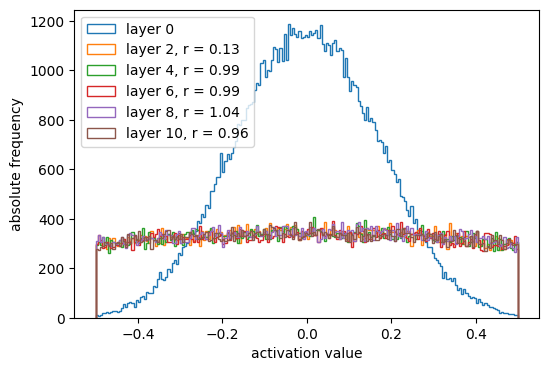

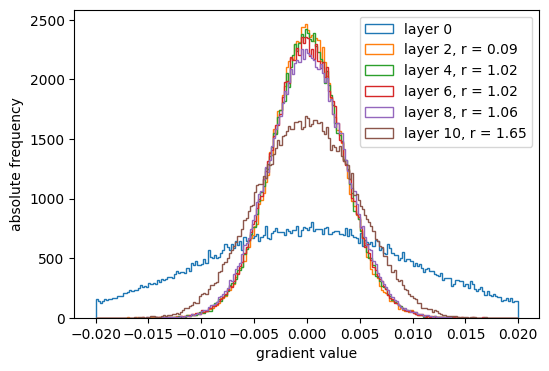

In [7]:
y = NNet.propagate(x, True)
NNet.back_propagate(y)

#you may have to adjust the disply range to optimise the graphical view
plot_activation_histogram(range = [-0.5,0.5])
plot_gradient_histogram(range = [-0.02,0.02])

# Unit Tests
### Unit Test for BatchNormLayer propagate

In [8]:
x_0 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,0.1,-0.3, 0.2,-1.0]).reshape(4,3)


#set seed to have reproducible weight and bias values
np.random.seed(1)
batchNormLayer = BatchNormLayer(3)

#choose non-trivial values for gamma and beta 
batchNormLayer.gamma = np.array([[1.2, 0.3, -1.4]])
batchNormLayer.beta = np.array([[-0.2, 1.8, 0.4]])

#do propagation
y_pred = batchNormLayer.propagate(x_0, True)

#compare with expected result
y_exp = np.array([[-0.39284403,  1.54322612, -0.34042881],
       [-0.39284403,  1.75945676,  1.73277186],
       [ 1.66415895,  2.30003334, -1.52511491],
       [-1.67847089,  1.59728378,  1.73277186]]
)

mu_avg_exp = np.array([[ 0.275,  0.575, -0.55 ]])
sigma_avg_exp = np.array([[0.4656984 , 0.553963  , 0.47169906]])

np.testing.assert_array_almost_equal(y_pred,y_exp,decimal=8)
np.testing.assert_array_almost_equal(batchNormLayer.mu_avg,mu_avg_exp,decimal=8)
np.testing.assert_array_almost_equal(batchNormLayer.sigma_avg,sigma_avg_exp,decimal=8)

### Unit Test for BatchNormLayer back_propagate
Assumes that Unit Test for propagate is correct¶

In [9]:
x_0 = np.array([0.2,0.1,-0.3, 0.2, 0.5,-1.0, 1.0,1.5,0.1,-0.3, 0.2,-1.0]).reshape(4,3)


#set seed to have reproducible weight and bias values
np.random.seed(1)
batchNormLayer = BatchNormLayer(3)

#choose non-trivial values for gamma and beta 
batchNormLayer.gamma = np.array([[1.2, 0.3, -1.4]])
batchNormLayer.beta = np.array([[-0.2, 1.8, 0.4]])

#do propagation
y_pred = batchNormLayer.propagate(x_0, True)
dL_da = batchNormLayer.back_propagate(y_pred)

dL_dbeta_exp = np.array([[-0.2, 1.8, 0.4]])
dL_dgamma_exp = np.array([[ 1.194863  ,  0.29891982, -1.39408284]])
dL_da_exp = np.array([[-2.12265436e-03, -4.99784266e-04,  9.26855963e-03],
       [-2.12265436e-03, -7.89133052e-05, -1.66834073e-02],
       [ 2.05189921e-02,  9.73264097e-04,  2.40982550e-02],
       [-1.62736834e-02, -3.94566526e-04, -1.66834073e-02]])

np.testing.assert_array_almost_equal(dL_da,dL_da_exp,decimal=8)
np.testing.assert_array_almost_equal(batchNormLayer.dL_dbeta,dL_dbeta_exp,decimal=8)
np.testing.assert_array_almost_equal(batchNormLayer.dL_dgamma,dL_dgamma_exp,decimal=8)